In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import mlab
from scipy import signal
import h5py, time
import sys
import glob
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
from tqdm import tqdm
import probfit


In [23]:
mean = [0, 0]
cov = [[12, 2], [21, 54]]  # diagonal covariance

In [33]:
x, y = np.random.multivariate_normal(mean, cov, 500).T
z, xedges,yedges = np.histogram2d(x,y, bins= (10,10))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [34]:
x_bin_center = 0.5*(xedges[1:]+xedges[:-1])
y_bin_center = 0.5*(yedges[1:]+yedges[:-1])

x_mesh, y_mesh = np.meshgrid(x_bin_center, y_bin_center)
x_mesh_ravel = x_mesh.ravel()
y_mesh_ravel = y_mesh.ravel()

data_z_ravel = z.ravel()
z_error = np.sqrt(data_z_ravel)

No handles with labels found to put in legend.


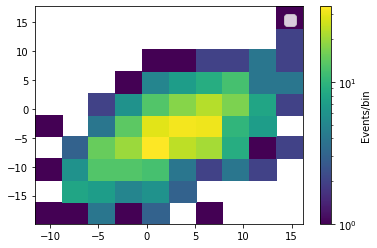

In [35]:
plot_bins = 256
xplot = np.linspace(x[0],x[-1],plot_bins)
yplot= np.linspace(y[0],y[-1],plot_bins)

xplot,yplot = np.meshgrid(xplot,yplot)


fig, ax = plt.subplots(1, 1)

plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm())

plt.colorbar(label = "Events/bin")
#plt.xlabel('$cs1$ [pe]')
#plt.ylabel('$cs2_b/100$ [pe]')


plt.legend(fancybox=True, fontsize = 15)

In [36]:
def two_dimensional_gaussian_XENONStyle(data_x,data_y,params=list):
    g1 = np.power((((data_x-params[1])*np.cos(params[3])-(data_y-params[2])*np.sin(params[3]))/params[4]),2)
    g2 = np.power((((data_x-params[1])*np.sin(params[3])+(data_y-params[2])*np.cos(params[3]))/params[5]),2)
    #g2 = ((data_x-params[2])/params[4]);   
    return params[0]*np.exp(-0.5*(g1+g2))+params[6]
 
    
def two_dimensional_gaussian_Akiostyle(data_x,data_y,params=list):
    g1 = ((data_x-params[1])/params[2])
    g2 = ((data_x-params[2])/params[4])
    return params[0]*np.exp(-0.5*(g1**2+g2**2))

# checked both, equivalent, but akios are formulated in a convolved parameter way

In [37]:
def chisquare_2d(function, data_x, data_y,data_z,data_z_error, functionparams=list):
    chisquarevaluex=np.sum(np.power(np.divide(np.subtract(function(data_x,data_y,functionparams),data_z),data_z_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevaluex, ndf)

def chisquare_2d_gaus_xenon(amp,x0,y0,theta,a,b,const):
    return chisquare_2d(function=two_dimensional_gaussian_XENONStyle,functionparams=[amp,x0,y0,theta,a,b,const],data_x=data_x,data_y=data_y,data_z=data_z,data_z_error=data_z_error)[0]


In [38]:
data_x = x_mesh_ravel
data_y = y_mesh_ravel
data_z = data_z_ravel
data_z_error = np.sqrt(data_z) + 1
m2=Minuit(chisquare_2d_gaus_xenon,amp=70,fix_amp=False,x0=0,fix_x0=False,y0=0,fix_y0=False,theta=0.1,a=1,b=1,const=0,errordef = 1,print_level=1)
m2.migrad(ncall=500000)
print(m2.values["amp"],m2.values["x0"],m2.values["y0"],m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"])
print()
#plt.title("%s" %i)
#plt.plot(FreqTF,transfer_function1(data_x,params=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]))
#plt.plot(FreqTF,TF[i][i])
#plt.yscale("log")
#plt.show()

------------------------------------------------------------------
| FCN = 25.56                   |     Ncalls=805 (805 total)     |
| EDM = 2.37E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
34.37198403330778 3.06223863596984 -3.76096526224739 -0.8213711874327075 6.740197338277839 3.3020566249239374 -0.01787150394827876



/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
  """


In [39]:
arg_list = [m2.values["amp"],m2.values["x0"],m2.values["y0"],m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"]]
#arg_list = [10,0,0,0.5,5,3,0]

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  from ipykernel import kernelapp as app


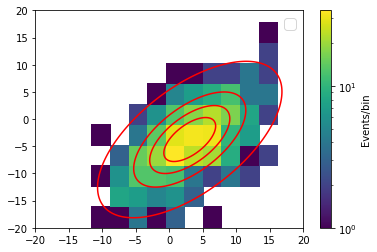

In [46]:
plot_bins = 256
xplot = np.linspace(-20,20,plot_bins)
yplot= np.linspace(-20,20,plot_bins)

xplot,yplot = np.meshgrid(xplot,yplot)

fig, ax = plt.subplots(1, 1)

plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm(), cmap="viridis")
plt.colorbar(label = "Events/bin")
plt.legend(fancybox=True, fontsize = 15)

lines = np.linspace(1, np.max(two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list)),5)
        
ax.contour(xplot, yplot, two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list), lines, colors='r', label="Fit")
plt.show()